# Ungraded Lab: Mask R-CNN Image Segmentation Demo

## Installation

In [1]:
# Clone the tensorflow models repository
# !git clone --depth 1 https://github.com/tensorflow/models
    
# uncomment the next line if you want to delete an existing models directory
!rm -rf ./models/

# clone the Tensorflow Model Garden
!git clone --depth 1 https://github.com/tensorflow/models/

Cloning into 'models'...
remote: Enumerating objects: 4109, done.
remote: Counting objects: 100% (4109/4109), done.
remote: Compressing objects: 100% (3112/3112), done.
remote: Total 4109 (delta 1190), reused 1979 (delta 935), pack-reused 0
Receiving objects: 100% (4109/4109), 45.36 MiB | 40.35 MiB/s, done.
Resolving deltas: 100% (1190/1190), done.


In [2]:
# # Compile the Object Detection API protocol buffers and install the necessary packages
# !cd models/research/ && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

# For compatibility. Pin tf-models-official version so it will use Tensorflow 2.15.
!sed -i 's/tf-models-official>=2.5.1/tf-models-official==2.15.0/g' ./models/research/object_detection/packages/tf2/setup.py

# Compile the Object Detection API protocol buffers and install the necessary packages
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

/usr/bin/sh: 1: protoc: not found


## Import libraries

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from six import BytesIO
from PIL import Image
from six.moves.urllib.request import urlopen

# from object_detection.utils import label_map_util
# from object_detection.utils import visualization_utils as viz_utils
# from object_detection.utils import ops as utils_ops

# tf.get_logger().setLevel('ERROR')

%matplotlib inline

E0000 00:00:1721907570.384053      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D0725 11:39:30.392745143      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0725 11:39:30.392760762      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0725 11:39:30.392764482      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0725 11:39:30.392767266      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0725 11:39:30.392770070      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

In [4]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = (image.size)
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


# dictionary with image tags as keys, and image paths as values
TEST_IMAGES = {
  'Beach' : 'models/research/object_detection/test_images/image2.jpg',
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # By 663highland, Source: https://commons.wikimedia.org/wiki/File:Kitano_Street_Kobe01s5s4110.jpg
  'Street' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Kitano_Street_Kobe01s5s4110.jpg/2560px-Kitano_Street_Kobe01s5s4110.jpg'
}

## Load the Model

In [5]:
model_display_name = 'Mask R-CNN Inception ResNet V2 1024x1024'
model_handle = 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:Mask R-CNN Inception ResNet V2 1024x1024
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1


In [6]:
# This will take 10 to 15 minutes to finish
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...


I0000 00:00:1721907628.447599      13 service.cc:145] XLA service 0x5c490c69db10 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721907628.447653      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1721907628.447658      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1721907628.447661      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1721907628.447664      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1721907628.447667      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1721907628.447670      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1721907628.447673      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1721907628.447676      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


model loaded!


## Inference

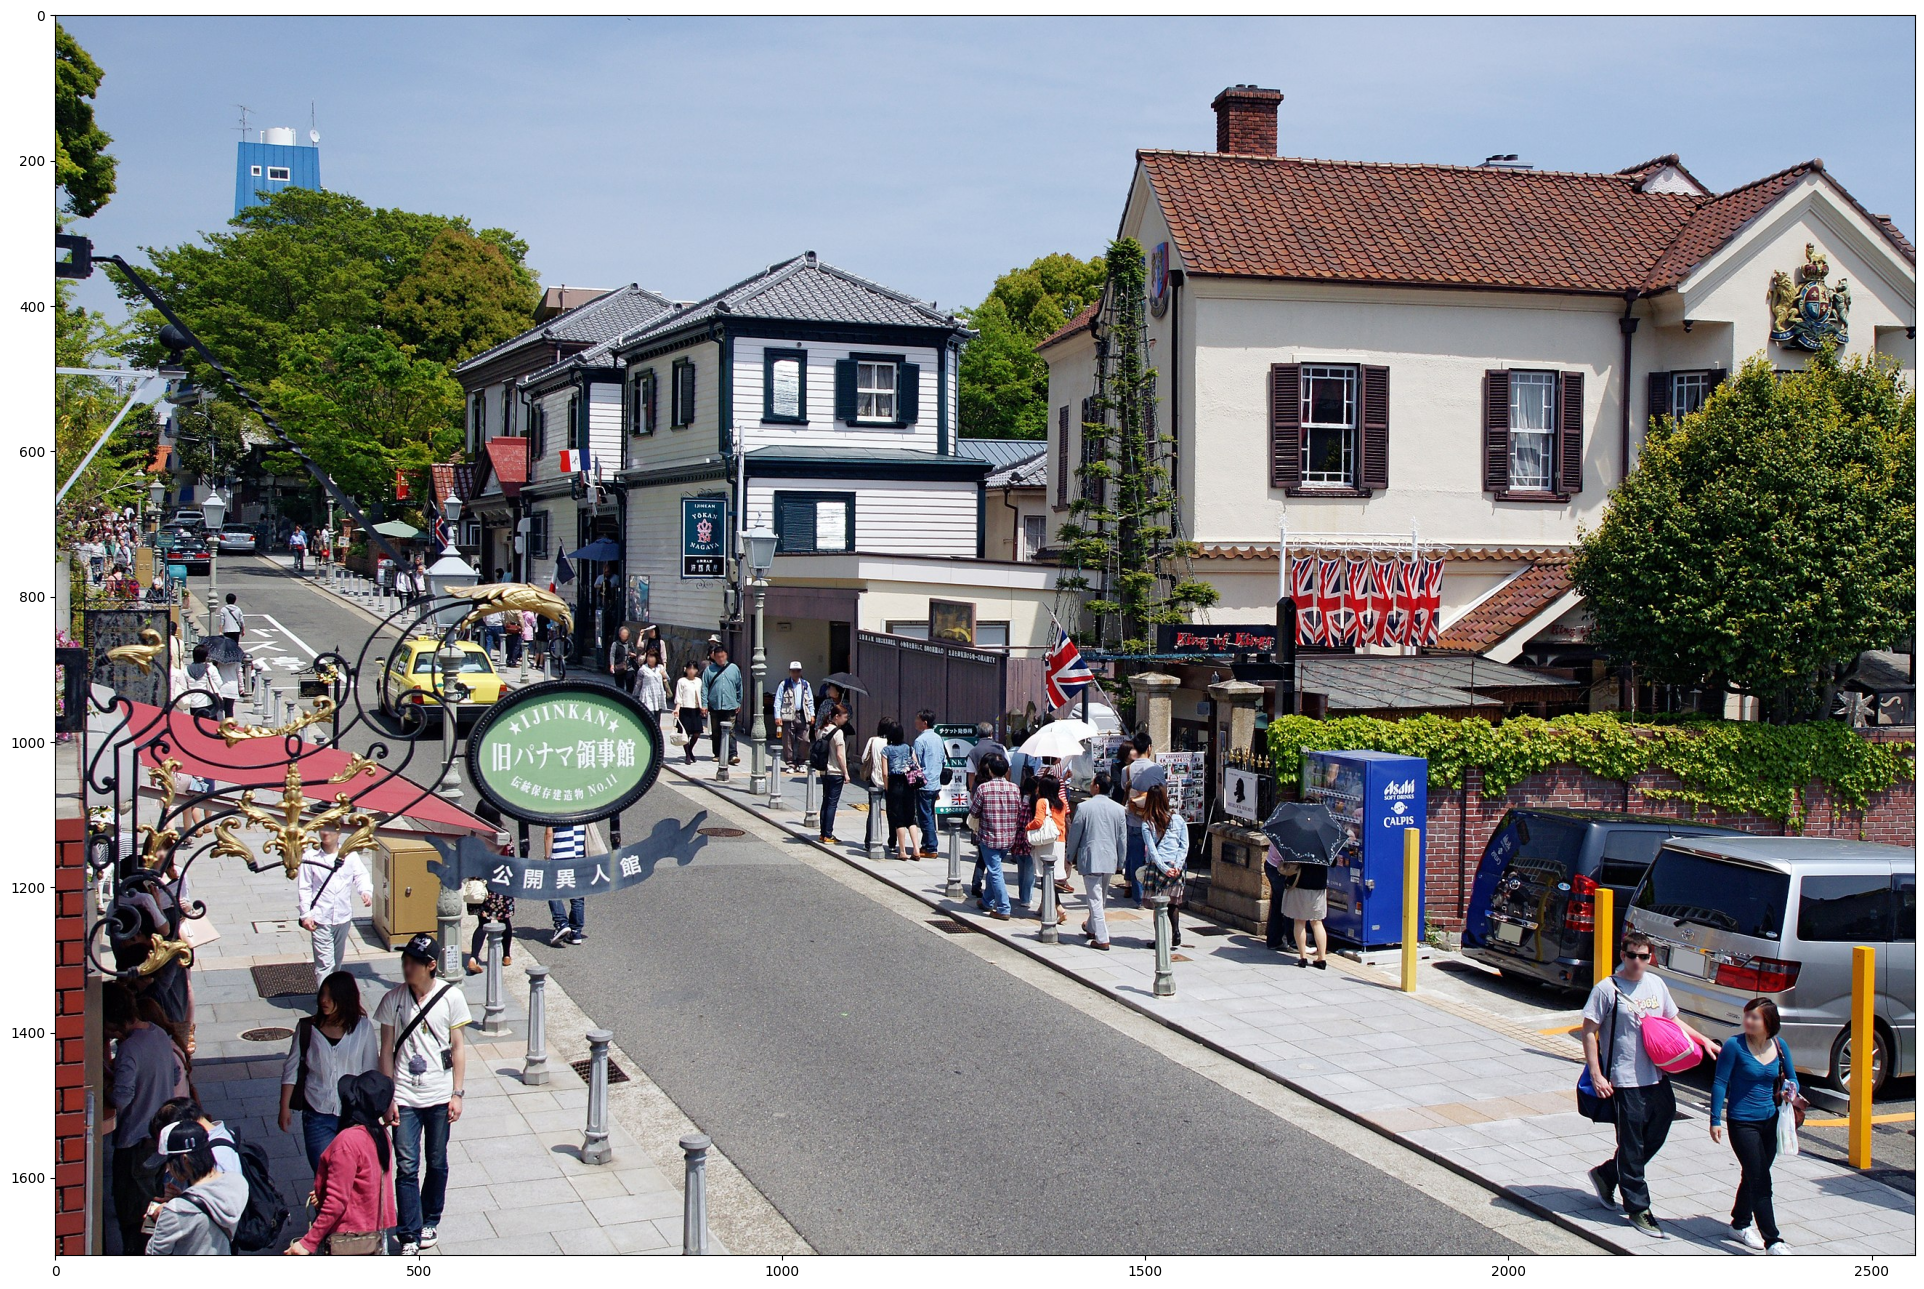

In [7]:
# Choose one and use as key for TEST_IMAGES below: 
# ['Beach', 'Street', 'Dogs','Phones']

image_path = TEST_IMAGES['Street']

image_np = load_image_into_numpy_array(image_path)

plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

In [8]:
# run inference
results = hub_model(image_np)

# output values are tensors and we only need the numpy() 
# parameter when we visualize the results
result = {key:value.numpy() for key,value in results.items()}

# print the keys
for key in result.keys():
  print(key)

rpn_objectness_predictions_with_background
num_detections
detection_multiclass_scores
detection_anchor_indices
detection_classes
raw_detection_boxes
anchors
detection_masks
rpn_features_to_crop
num_proposals
raw_detection_scores
proposal_boxes
rpn_box_encodings
box_classifier_features
proposal_boxes_normalized
detection_boxes
final_anchors
refined_box_encodings
rpn_box_predictor_features
class_predictions_with_background
detection_scores
image_shape
mask_predictions


## Visualizing the results

In [9]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# sample output
print(category_index[1])
print(category_index[2])
print(category_index[4])

NameError: name 'label_map_util' is not defined